In [1]:
import os
import toml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from toolz import partial
from tqdm.auto import tqdm

from rl_analysis.util import zscore
from sklearn.linear_model import LinearRegression
from rl_analysis.photometry.signal import rolling_fluor_normalization, rereference

from pynwb import NWBHDF5IO
from pathlib import Path
import yaml

from stream_nwbfile import stream_nwbfile

DANDISET_ID = '000559'
file_paths = [
    'sub-dls-dlight-9/sub-dls-dlight-9_ses-keypoint-dls-dlight-9_image+ophys.nwb',
    'sub-dls-dlight-10/sub-dls-dlight-10_ses-keypoint-dls-dlight-10_image+ophys.nwb',
    'sub-dls-dlight-11/sub-dls-dlight-11_ses-keypoint-dls-dlight-11_image+ophys.nwb',
    'sub-dls-dlight-12/sub-dls-dlight-12_ses-keypoint-dls-dlight-12_image+ophys.nwb',
    'sub-dls-dlight-13/sub-dls-dlight-13_ses-keypoint-dls-dlight-13_image+ophys.nwb'
]


nwbfiles, ios = zip(*[stream_nwbfile(DANDISET_ID, file_path) for file_path in tqdm(file_paths)])

  0%|          | 0/5 [00:00<?, ?it/s]

A newer version (0.59.1) of dandi/dandi-cli is available. You are using 0.54.0
/opt/anaconda3/envs/datta_figureS3_env/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/datta_figureS3_env/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [2]:
def _partial(df, x, y, window=range(-30, 30)):
    # new approach - remove transfer function here
    X = [df[x].shift(i).rename(index=str(i)) for i in window]
    X = pd.DataFrame(X).T

    X[y] = df[y]
    X = X.dropna()

    mdl = LinearRegression()
    mdl.fit(X.drop(columns=[y]), X[y])
    p = mdl.predict(X.drop(columns=[y]))
    df.loc[X.index, f"{y} partial"] = X[y] - p
    df[f"{y} partial (z)"] = zscore(df[f"{y} partial"])
    return df


# rereference the dLight signal to remove motion artifact
def filter_signal(v):
    sos = signal.butter(2, 3, output="sos", fs=30.0)
    f = signal.sosfiltfilt(sos, v)
    return f


def get_z(x, y, bw_adjust=1, subsample_factor=100):
    from scipy.stats import gaussian_kde

    xy = np.vstack([x[::subsample_factor], y[::subsample_factor]])
    kernel = gaussian_kde(xy)
    kernel.set_bandwidth(kernel.scotts_factor() * bw_adjust)
    z = kernel(np.vstack([x, y]))
    return z


def partial_out(df, xs, y):
    assert isinstance(xs, list)
    X = df[xs]
    y = df[y]
    mdl = LinearRegression()
    mdl.fit(X, y)
    p = mdl.predict(X)
    return zscore(y - p)


def compute_keypoint_velocity(kp, n=2):
    return (kp[n:] - kp[:-n]) / n


def compute_global_velocity(kp, n=2):
    # nframes X nkeypoints X 3
    kp = np.nanmean(kp[:, :3], axis=1)
    v = (kp[n:] - kp[:-n]) / n
    # only consider the first 3 points as they are the spine
    return np.linalg.norm(v, axis=1)


def bin_data(data, timescale, n_offsets=0, neural_agg="mean", data_agg="mean", window=range(-15, 15)):
    step = timescale / (n_offsets + 1)
    offsets = np.arange(0, timescale, step)

    time = np.arange(0, 1500, timescale)  # step through 0-1500 seconds at this timescale

    aggs = []
    for offset in offsets:
        cuts = pd.cut(data["timestamp"], time + offset, labels=False).astype("Int16").rename("time bin")
        data["time bin"] = cuts
        agg = data.groupby(["mouse_id", "time bin"]).agg(neural_agg)
        agg["offset"] = offset
        aggs.append(agg)
    agg_matrix = pd.concat(aggs).reset_index()
    agg_matrix["timescale"] = timescale
    agg_matrix = agg_matrix.sort_values(by=["mouse_id", "timestamp"])

    # partial out velocity
    for dim in ("2d", "3d"):
        agg_matrix = agg_matrix.groupby("mouse_id", group_keys=False).apply(
            _partial, x=f"body speed {dim} (z)", y=f"forelimb speed {dim} (z)", window=window
        )
    # partial out 2d velocity from 3d forelimb speed
    agg_matrix = agg_matrix.groupby("mouse_id", group_keys=False).apply(
        _partial, x="body speed 2d (z)", y="forelimb speed 3d (z)", window=window
    )
    # partial velocity from dlight
    agg_matrix = agg_matrix.groupby("mouse_id", group_keys=False).apply(
        _partial, x="body speed 2d (z)", y="dlight_reref_dff (z)", window=window
    )

    if isinstance(neural_agg, str):
        agg_matrix["neural_agg"] = neural_agg
    elif hasattr(neural_agg, "__name__"):
        agg_matrix["neural_agg"] = neural_agg.__name__

    return agg_matrix

In [3]:
def reproduce_figS3(nwbfile_paths, nwbfiles, config_path, metadata, ios):
    print("reproducing figure S3")
    with open(config_path, "r") as f:
        config = toml.load(f)
    dlight_config = config["dlight_basic_analysis"]
    index_to_name = metadata["Keypoint"]["index_to_name"]
    data = {}
    for nwbfile, nwbfile_path in zip(nwbfiles, nwbfile_paths):
        timestamps = (
            nwbfile.processing["behavior"]
            .data_interfaces["keypoints"]
            .pose_estimation_series["rostral_spine"]
            .timestamps[:]
        )
        positions_median = np.zeros((len(timestamps), 15, 3))
        for i, name in index_to_name.items():
            positions_median[:, i, :] = (
                nwbfile.processing["behavior"].data_interfaces["keypoints"].pose_estimation_series[name].data[:]
            )
        data[os.path.basename(nwbfile_path)] = {
            "dlight": nwbfile.processing["ophys"].data_interfaces["SignalF"].data[:],
            "uv": nwbfile.processing["ophys"].data_interfaces["UVReferenceF"].data[:],
            "positions_median": positions_median,
        }
        summary_image = (
            nwbfile.processing["behavior"].data_interfaces["summary_images"].images["summary_image"].data[:]
        )

    plot_3a(summary_image=summary_image)

    window = range(-10, 10)
    dfs = {}

    for k, v in data.items():
        speed = compute_global_velocity(v["positions_median"])
        kp_vels = compute_keypoint_velocity(v["positions_median"])
        kp_speed = np.linalg.norm(kp_vels, axis=2)

        speed_2d = compute_global_velocity(v["positions_median"][..., :2])
        kp_vels_2d = compute_keypoint_velocity(v["positions_median"][..., :2])
        kp_speed_2d = np.linalg.norm(kp_vels_2d, axis=2)

        dlight_df = pd.DataFrame(
            {
                "dLight": rolling_fluor_normalization(v["dlight"][2:], normalizer="zscore"),
                "body speed 3d": speed,
                "right forepaw 3d": kp_speed[:, 14],
                "left forepaw 3d": kp_speed[:, 13],
                "right hindpaw 3d": kp_speed[:, 12],
                "left hindpaw 3d": kp_speed[:, 10],
                "forelimb speed 3d": np.nanmean(kp_speed[:, [13, 14]], axis=1),
                "hindlimb speed 3d": np.nanmean(kp_speed[:, [10, 12]], axis=1),
                "body speed 2d": speed_2d,
                "right forepaw 2d": kp_speed_2d[:, 14],
                "left forepaw 2d": kp_speed_2d[:, 13],
                "right hindpaw 2d": kp_speed_2d[:, 12],
                "left hindpaw 2d": kp_speed_2d[:, 10],
                "forelimb speed 2d": np.nanmean(kp_speed_2d[:, [13, 14]], axis=1),
                "hindlimb speed 2d": np.nanmean(kp_speed_2d[:, [10, 12]], axis=1),
                "mouse": k,
            }
        )
        y = []

        for dimension in ("2d", "3d"):
            X = [dlight_df[f"body speed {dimension}"].shift(i) for i in window]
            X = pd.DataFrame(np.array(X).T, columns=map(str, window), index=dlight_df.index)

            X[f"forelimb speed {dimension}"] = dlight_df[f"forelimb speed {dimension}"]
            X = X.dropna()

            mdl = LinearRegression()

            mdl.fit(
                X.drop(columns=[f"forelimb speed {dimension}"]),
                X[[f"forelimb speed {dimension}"]],
            )

            X[f"forelimb partial {dimension}"] = (
                X[f"forelimb speed {dimension}"]
                - mdl.predict(X.drop(columns=[f"forelimb speed {dimension}"])).squeeze()
            )
            X[f"forelimb partial {dimension} (z)"] = zscore(X[f"forelimb partial {dimension}"])
            X[f"forelimb speed {dimension} (z)"] = zscore(X[f"forelimb speed {dimension}"])
            if dimension == "2d":
                X["dLight"] = dlight_df["dLight"]
                X["dLight (z)"] = zscore(X["dLight"])
                X["timestamp"] = np.arange(len(X)) / 30
                X["mouse_id"] = k
            X[f"speed {dimension} (z)"] = zscore(X["0"])

            y.append(X.drop(columns=map(str, window)))
        dfs[k] = pd.concat(y, axis=1)

    df = pd.concat(dfs.values())

    secs = 30 * 10
    threshold = 1.96
    window = range(-secs, secs)
    dff_func = partial(rolling_fluor_normalization, window_size=5, quantile=0.1, normalizer="dff")
    dfs = {}

    for k, v in tqdm(data.items()):
        speed = compute_global_velocity(v["positions_median"])
        kp_vels = compute_keypoint_velocity(v["positions_median"])
        kp_speed = np.linalg.norm(kp_vels, axis=2)

        speed_2d = compute_global_velocity(v["positions_median"][..., :2])
        kp_vels_2d = compute_keypoint_velocity(v["positions_median"][..., :2])
        kp_speed_2d = np.linalg.norm(kp_vels_2d, axis=2)

        signal_dff = dff_func(v["dlight"][2:])
        reference_dff = dff_func(v["uv"][2:])

        dlight_df = pd.DataFrame(
            {
                "dlight_dff": signal_dff,
                "reference_dff": reference_dff,
                "body speed 3d": speed,
                "right forepaw 3d": kp_speed[:, 14],
                "left forepaw 3d": kp_speed[:, 13],
                "right hindpaw 3d": kp_speed[:, 12],
                "left hindpaw 3d": kp_speed[:, 10],
                "forelimb speed 3d": np.nanmean(kp_speed[:, [13, 14]], axis=1),
                "hindlimb speed 3d": np.nanmean(kp_speed[:, [10, 12]], axis=1),
                "body speed 2d": speed_2d,
                "right forepaw 2d": kp_speed_2d[:, 14],
                "left forepaw 2d": kp_speed_2d[:, 13],
                "right hindpaw 2d": kp_speed_2d[:, 12],
                "left hindpaw 2d": kp_speed_2d[:, 10],
                "forelimb speed 2d": np.nanmean(kp_speed_2d[:, [13, 14]], axis=1),
                "hindlimb speed 2d": np.nanmean(kp_speed_2d[:, [10, 12]], axis=1),
                "height": v["positions_median"][2:, 5, 2],
                "mouse_id": k,
                "timestamp": np.arange(len(speed)) / 30,
            }
        )
        nans = dlight_df["dlight_dff"].isna()
        x = dlight_df.loc[~nans]
        dlight_df["dlight_reref_dff"] = rereference(
            pd.Series(filter_signal(x["reference_dff"]), index=x.index),
            x["dlight_dff"],
            center=False,
            clip=False,
        )["rereference"]
        dlight_df["dlight_reref_dff"] = rolling_fluor_normalization(
            dlight_df["dlight_reref_dff"], normalizer="zscore", window_size=20
        )
        z_cols = [x for x in dlight_df.columns if x not in ("mouse_id", "timestamp")]

        dlight_df[[f"{c} (z)" for c in z_cols]] = zscore(dlight_df[z_cols])
        dlight_df["peak_rate_cross"] = 0
        z = dlight_df["dlight_reref_dff (z)"].to_numpy()
        dlight_df.loc[dlight_df.index[1:], "peak_rate_cross"] = (z[:-1] < threshold) & (z[1:] > threshold)
        y = []

        # partial body speed from dLight
        dlight_df = _partial(dlight_df, x="body speed 2d (z)", y="dlight_reref_dff (z)", window=window)

        dfs[k] = dlight_df
    df = pd.concat(dfs.values())
    df["peak_rate_cross"] = df["peak_rate_cross"].astype(float)

    results = bin_data(data=df, timescale=0.4, n_offsets=0, window=range(1))

    forelimb_partial = results.groupby("mouse_id", sort=False).apply(
        partial_out,
        xs=[
            "height",
            "body speed 2d",
            "body speed 3d",
        ],
        y="forelimb speed 3d",
    )
    results["forelimb_partial"] = forelimb_partial.droplevel(0)

    forelimb_partial = results.groupby("mouse_id", sort=False).apply(
        partial_out,
        xs=[
            "height",
            "body speed 2d",
            "body speed 3d",
        ],
        y="dlight_reref_dff (z)",
    )
    results["dlight_partial"] = forelimb_partial.droplevel(0)

    corrs = results.groupby(["timescale", "mouse_id", "neural_agg"]).corr(method="pearson")
    corrs.index = corrs.index.rename("feature", level=-1)
    plot_3c(results=results)

    timescales = np.arange(*dlight_config["timescale_correlation"]["bins"])

    func = partial(bin_data, data=df, n_offsets=4, window=range(1))
    results_list = [func(timescale=t) for t in tqdm(timescales)]

    results = pd.concat(results_list)

    corrs = results.groupby(["timescale", "mouse_id", "neural_agg"]).corr(method="pearson")
    corrs.index = corrs.index.rename("feature", level=-1)
    plot_3b(corrs=corrs)

    for io in ios:
        io.close()


def plot_3a(summary_image):
    fig = plt.figure()
    plt.imshow(summary_image)
    plt.show()


def plot_3c(results):
    tmp = results.dropna()
    x = tmp["dlight_reref_dff (z)"]
    y = tmp["body speed 2d (z)"]
    z = get_z(x, y, 1, subsample_factor=100)

    fig = plt.figure(figsize=(2, 2), dpi=300)
    plt.scatter(x, y, c=z, s=2, alpha=0.3, cmap="inferno", linewidths=0)
    ax = sns.regplot(
        data=results,
        x="dlight_reref_dff (z)",
        y="body speed 2d (z)",
        n_boot=100,
        line_kws=dict(color="darkorange"),
        ci=95,
        scatter=False,
    )
    ax.set(ylabel="2D velocity (z)", xlabel="dF/F0 (z)")
    sns.despine()
    plt.xlabel("dF/F0 (z)")
    plt.ylabel("2D velocity (z)")
    plt.show()

    tmp = results.dropna()
    x = tmp["dlight_partial"]
    y = tmp["forelimb speed 3d (z)"]
    z = get_z(x, y, 1, subsample_factor=100)

    fig = plt.figure(figsize=(2, 2), dpi=300)
    fig.dpi = 300
    plt.scatter(x, y, c=z, s=2, alpha=0.3, cmap="inferno", linewidths=0)
    ax = sns.regplot(
        data=results,
        x="dlight_partial",
        y="forelimb speed 3d (z)",
        n_boot=100,
        line_kws=dict(color="darkorange"),
        ci=95,
        scatter=False,
    )
    ax.set(ylabel="3D forelimb velocity (z)", xlabel="dF/F0 (partialed; z)")
    sns.despine()
    plt.xlabel("dF/F0 (partialed; z)")
    plt.ylabel("3D forelimb velocity (z)")
    plt.show()


def plot_3b(corrs):
    dlight_to_vel_corrs = corrs.xs("dlight_reref_dff (z)", level="feature")
    # dlight_to_vel_corrs = corrs.xs("dlight_dff", level="feature")

    c_ave = dlight_to_vel_corrs.groupby(["mouse_id", "timescale", "neural_agg"]).mean()
    c_ave = c_ave.melt(ignore_index=False)

    fig = plt.figure(figsize=(2, 2), dpi=200)
    ax = sns.lineplot(
        data=c_ave.reset_index(),
        x="timescale",
        y="value",
        hue="variable",
        n_boot=100,
        hue_order=["body speed 2d (z)"],
        errorbar=("ci", 68),
        err_kws=dict(lw=0),
    )
    ax.axhline(0, ls="--", c="k")
    ax.set(ylabel="Correlation (Pearson R)", xlabel="Bin duration (s)", ylim=(-0.25, 0.2))
    plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
    sns.despine()
    plt.show()

    dlight_to_vel_corrs = corrs.xs("peak_rate_cross", level="feature")
    c_ave = dlight_to_vel_corrs.groupby(["mouse_id", "timescale", "neural_agg"]).mean()
    c_ave = c_ave.melt(ignore_index=False)

    fig = plt.figure(figsize=(2, 2), dpi=200)
    ax = sns.lineplot(
        data=c_ave.reset_index(),
        x="timescale",
        y="value",
        hue="variable",
        n_boot=100,
        hue_order=["body speed 2d (z)"],
        errorbar=("ci", 68),
        err_kws=dict(lw=0),
    )
    ax.axhline(0, ls="--", c="k")
    ax.set(ylabel="Correlation (Pearson r)", xlabel="Bin duration (s)", ylim=(-0.25, 0.2))
    plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
    sns.despine()
    plt.show()

reproducing figure S3


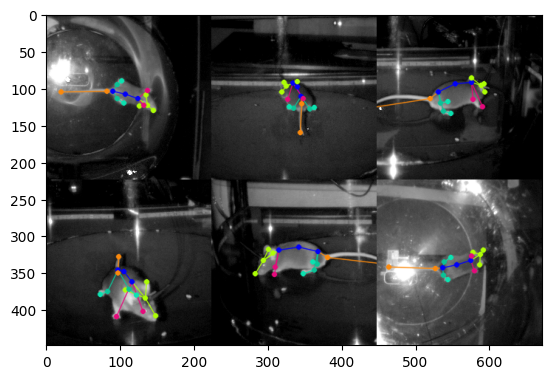

  0%|          | 0/5 [00:00<?, ?it/s]

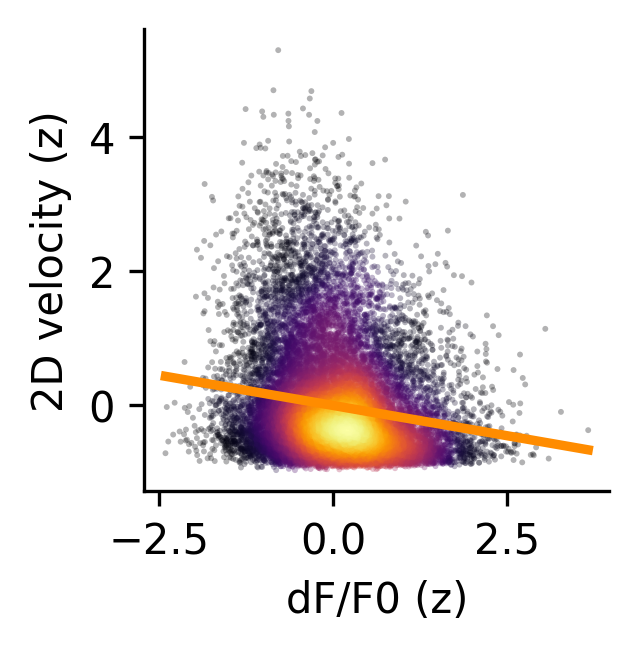

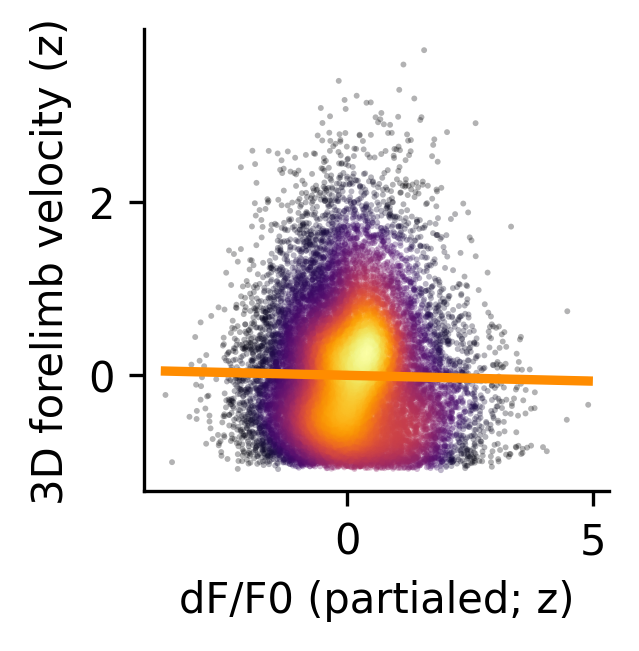

  0%|          | 0/120 [00:00<?, ?it/s]

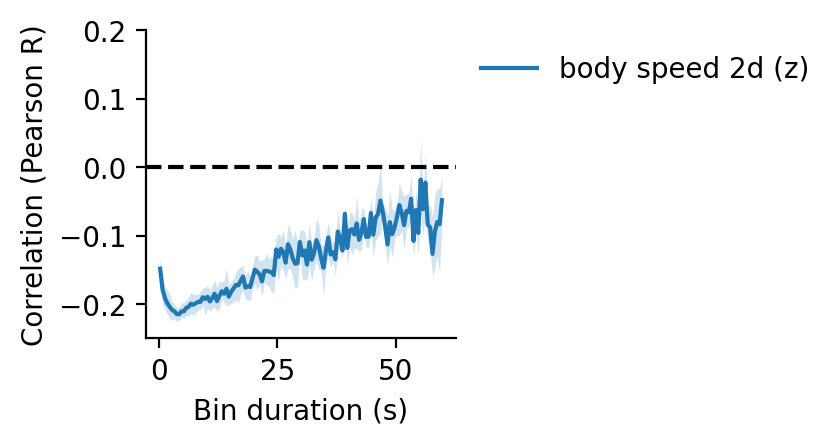

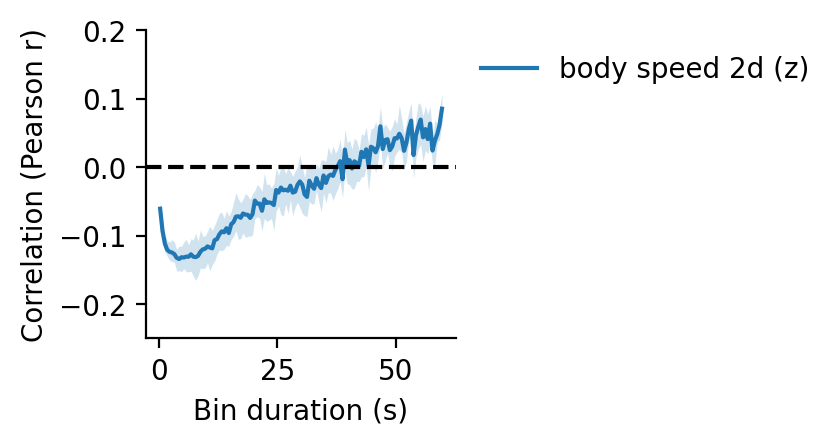

In [4]:
config_path = "analysis_configuration.toml"
metadata_path = "markowitz_gillis_nature_2023_keypoint_metadata.yaml"
with open(metadata_path,"r") as f:
    metadata = yaml.safe_load(f)
reproduce_figS3(nwbfile_paths=file_paths, nwbfiles=nwbfiles, config_path=config_path, metadata=metadata, ios=ios)